In this script, we plot two results of MM training result
- batch resampling
- class weighting

We also compared those two in the last figure.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import struct

import cartopy
from cartopy import crs as ccrs
import matplotlib 
from matplotlib import pyplot as plt
import os
from os.path import join, exists
from os import mkdir
import scipy
import netCDF4
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import pandas as pd
import matplotlib.path as mpath
from matplotlib.colors import TwoSlopeNorm 
from sklearn.model_selection import train_test_split
from scipy.fft import fft, ifft
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import pickle
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import importlib.util
import pathlib
import MM_util_AI
from sklearn.metrics import confusion_matrix,recall_score,precision_score
spec = importlib.util.spec_from_file_location("MM_dataprepare", \
                        "/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/MM_dataprepare.py")
MM_dataprepare = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = MM_dataprepare
spec.loader.exec_module(MM_dataprepare)
spec = importlib.util.spec_from_file_location("MM_utilblocking", \
                        "/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/MM_utilblocking.py")
MM_utilblocking = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = MM_utilblocking
spec.loader.exec_module(MM_utilblocking)
from sklearn.metrics import confusion_matrix,recall_score,precision_score
with open("/scratch/hz1994/blocking/data_MMmodel/filepath.txt","r") as fi:
    for ln in fi:
        if ln.startswith("Reduced_dim_variables"):
            rd_path=ln.strip().split('\t')[1]
        if ln.startswith("TMindex_filepath"):
            TMindex_path=ln.strip().split('\t')[1]   
        if ln.startswith("dimensionalized_filepath"):
            dim_path=ln.strip().split('\t')[1]   
        if ln.startswith("nondimensionalized_filepath"):
            nondim_path=ln.strip().split('\t')[1]
        if ln.startswith("conditionedT_filepath" ):
            train_path=ln.strip().split('\t')[1]
        if ln.startswith("model_filepath" ):
            models_path=ln.strip().split('\t')[1]
        if ln.startswith("fig_filepath" ):
            fig_path=ln.strip().split('\t')[1]            
            
print(rd_path)
print(TMindex_path)
print(dim_path)
print(train_path)
print(models_path)
print(fig_path)

def test_model(model,weightpath,test_data,test_labels,test_classlabels):
    model.load_weights(weightpath)
    predictions = model.predict(test_data)
    pred=(predictions[:,0]<predictions[:,1])
    bce=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss=bce(test_classlabels, predictions).numpy()
    TN,FP,FN,TP = confusion_matrix(test_labels, pred).flatten()
    recall=recall_score(test_labels, pred , labels=1 )
    precision=precision_score(test_labels, pred , labels=1 )
    return np.array([TN,FP,FN,TP]),recall,precision,loss

def plot_bunch_timeseqdist(ax, matrix,xt=None,  figtype="shades", number_lines=None, label=None,color=None,linestyle='-',alpha=1):
    #colomns are indicies, rows are time
    if xt is None:
        xt=np.arange(matrix.shape[1]) 
    if figtype=="shades":
        mean=np.nanmean(matrix,axis=0)
        std=np.nanstd(matrix,axis=0)
        p = ax.plot(xt,mean ,label=label,color=color,alpha=alpha,linestyle=linestyle)
        color=p[0].get_color()
        ax.plot(xt,mean-std,color=color,alpha=0. )
        ax.plot(xt,mean+std,color=color,alpha=0. )
        ax.fill_between(xt, mean-std, mean+std,color=color,alpha=0.1)
    elif figtype=="lines":
        p = ax.plot(xt,matrix.T ,color=color, label=label,alpha=alpha)
    else:
        print("Please specify the figtype (shades or lines).")
    return mean

import matplotlib as mpl

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)
plt.rcParams['axes.linewidth'] = 1.5

/ext3/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-04-02 08:22:36.274289: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 08:22:47.171131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 08:22:47.171157: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 08:22:47.196019: 

/scratch/hz1994/blocking/data_MMmodel/reduceddim/
/scratch/hz1994/blocking/data_MMmodel/TMindex/
/scratch/hz1994/blocking/data_MMmodel/dim/
/scratch/hz1994/blocking/data_MMmodel/conditionT/
/scratch/hz1994/blocking/data_MMmodel/CNNmodels/
/scratch/hz1994/blocking/data_MMmodel/fig_MMmodel/


In [2]:
T=1
EPOCH=30
name="1250k_lowpass3dys"
epsilon=0
choleskyL=np.load('/scratch/hz1994/blocking/data_MMmodel/conditionT/T/cholesky_L.npy') 
setA="T"
train_path_setA=train_path+setA+"/"
models_path_setA=models_path+setA+"/"
Ysparse=np.load(train_path+"/T/full/"+"data_Y_T%d_"%1+"1250k_lowpass3dys"+".npy")
print("climatological mean=",Ysparse.sum()/Ysparse.size)

climatological mean= 0.21210544179205792


In [12]:
cnnsize_list=["normal"]
data_amount_list=['1.0k','10.0k','100.0k','500.0k','1000.0k']
random_seed_list=np.arange(30,40)

#The data are all in /scratch/hz1994/blocking/data_MMmodel/CNNmodels/T/models_T_1_committor_1250k_lowpass3dys/"+\
#  "batches_resampling_data_1.0k_normal_cnn_regularize_0.000e+00_rs_%d/, and if recompute==True we will connect those together
# as the input of plotting Fig5.
recompute=True
if recompute:
    for d, data_amount in enumerate(data_amount_list):
        precision=[]
        recall=[]
        for random_seed in random_seed_list:
            subname="/batches_resampling_"+"data_"+data_amount+"_"+"normal"+"_cnn_"+\
                "regularize"+"_%.3e"%epsilon+"_rs_%d/"%random_seed
            path = models_path_setA+'models_T_%d_committor_'%T+name+subname   
            precision.append(np.load(path+"precision.npy")[1:])
            recall.append(np.load(path+"recall.npy")[1:])   
        precision=np.array(precision)
        recall=np.array(recall) 
        np.save(models_path_setA+'models_T_%d_committor_'%T+name+"/Fig5_plot_precision_%s.npy"%data_amount,precision )
        np.save(models_path_setA+'models_T_%d_committor_'%T+name+"/Fig5_plot_recall_%s.npy"%data_amount,recall )

# Animation

epoch=4, precision=0.696
epoch=4, recall=0.868
epoch=4, precision=0.684
epoch=4, recall=0.850
epoch=4, precision=0.660
epoch=4, recall=0.791
epoch=4, precision=0.609
epoch=4, recall=0.695
epoch=4, precision=0.370
epoch=4, recall=0.582


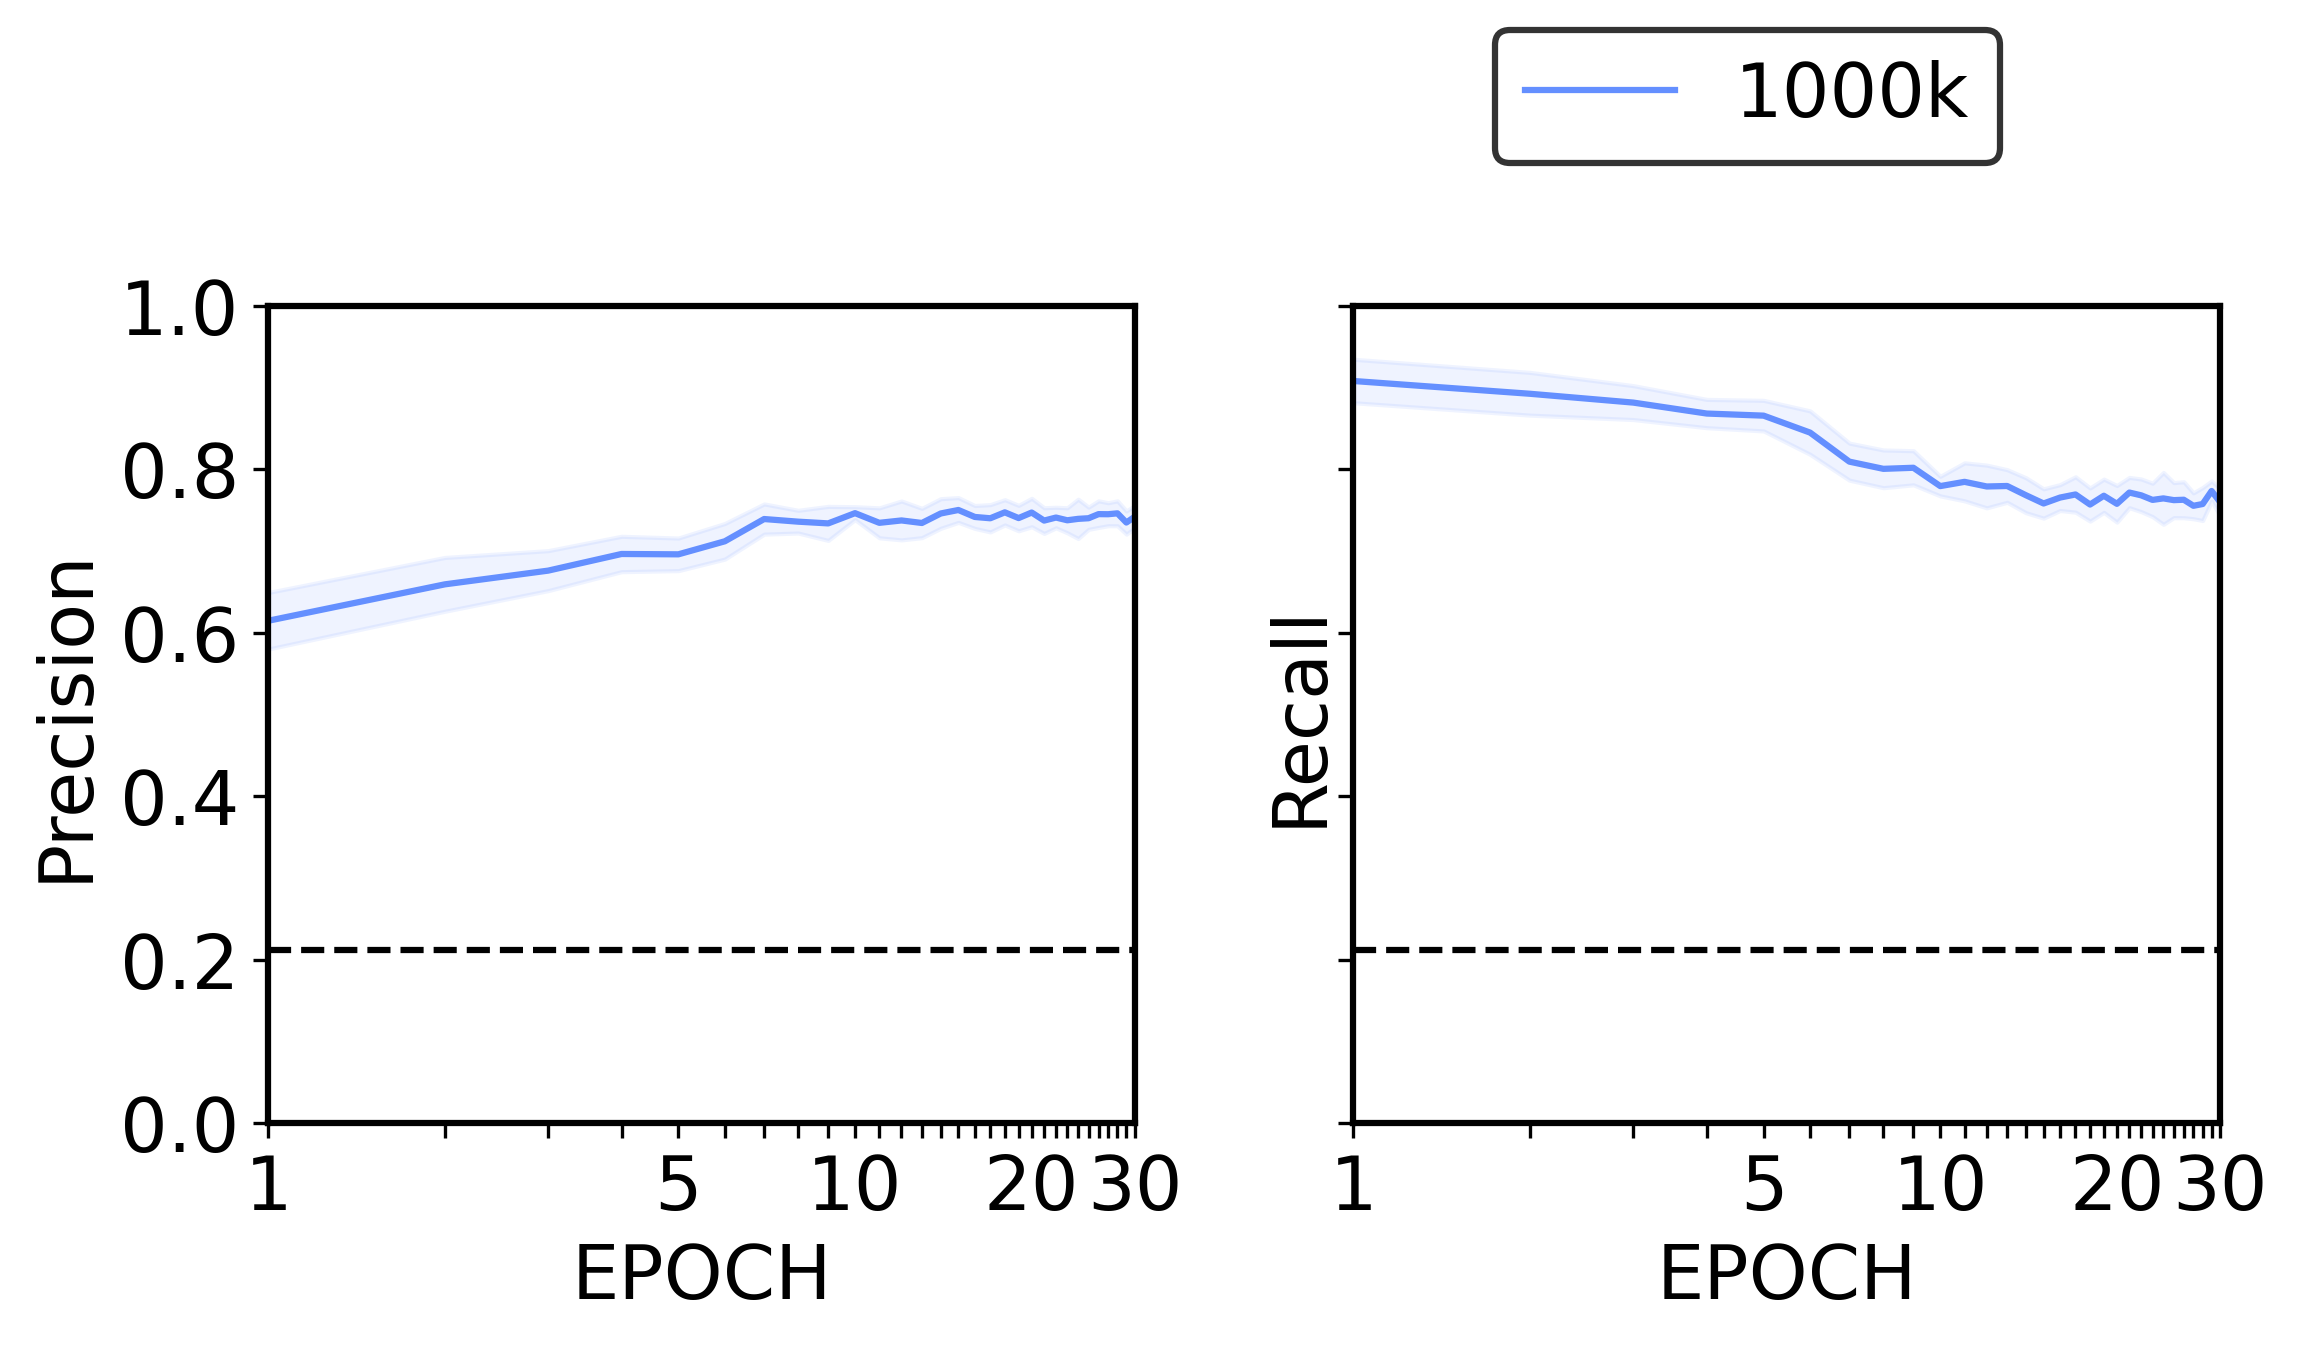

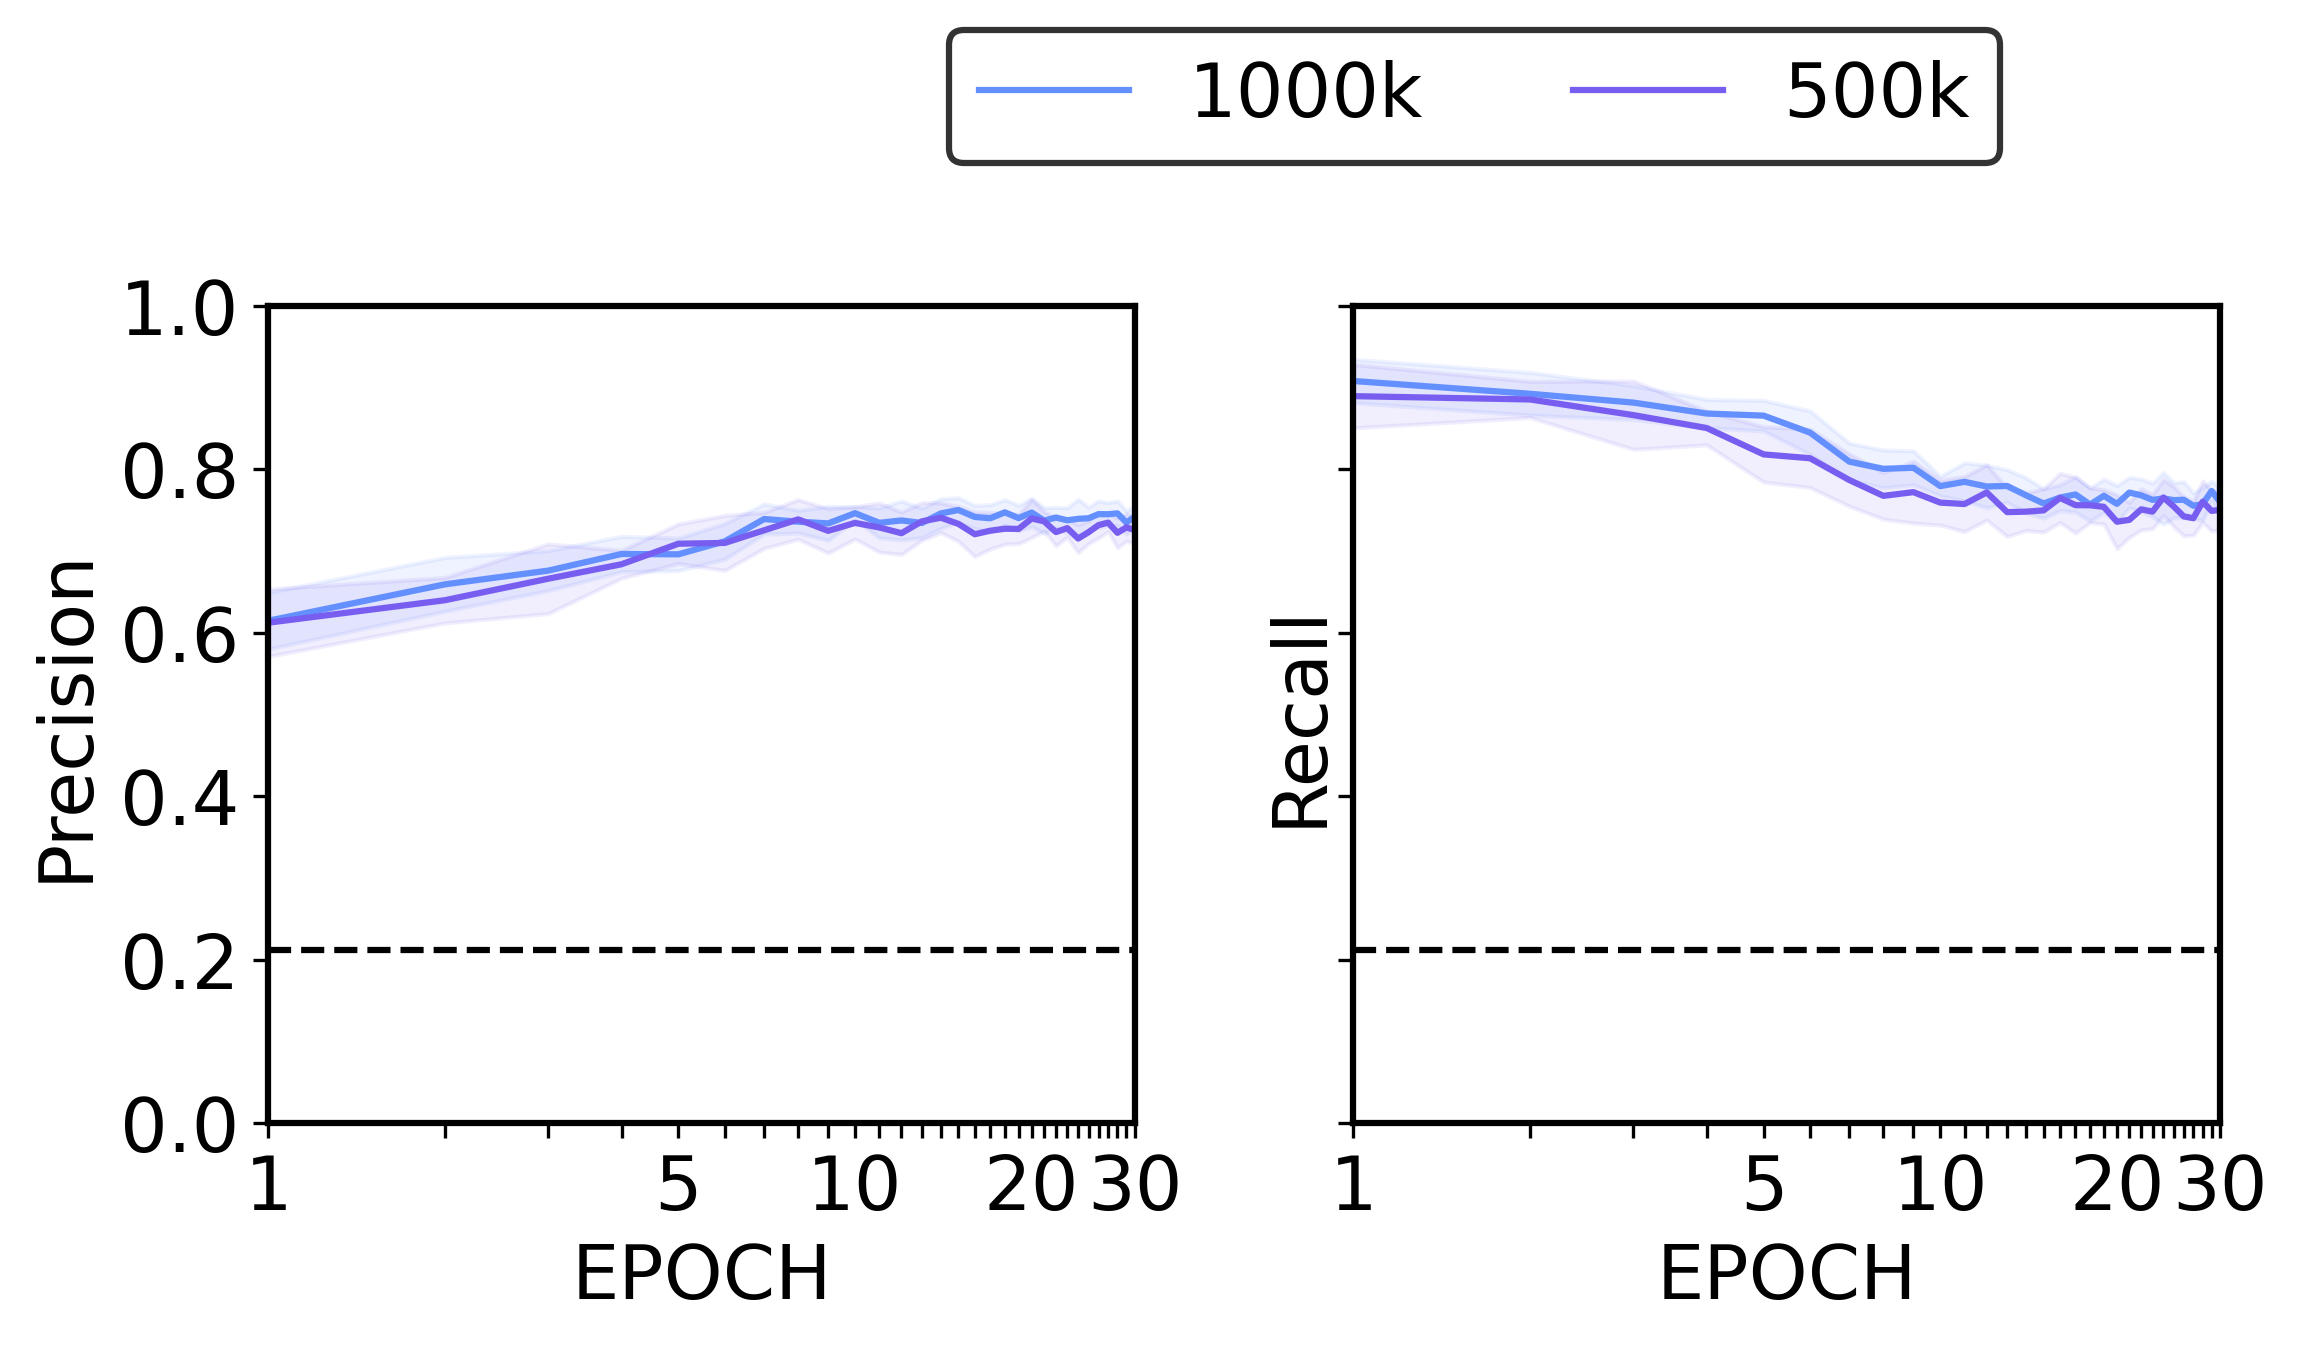

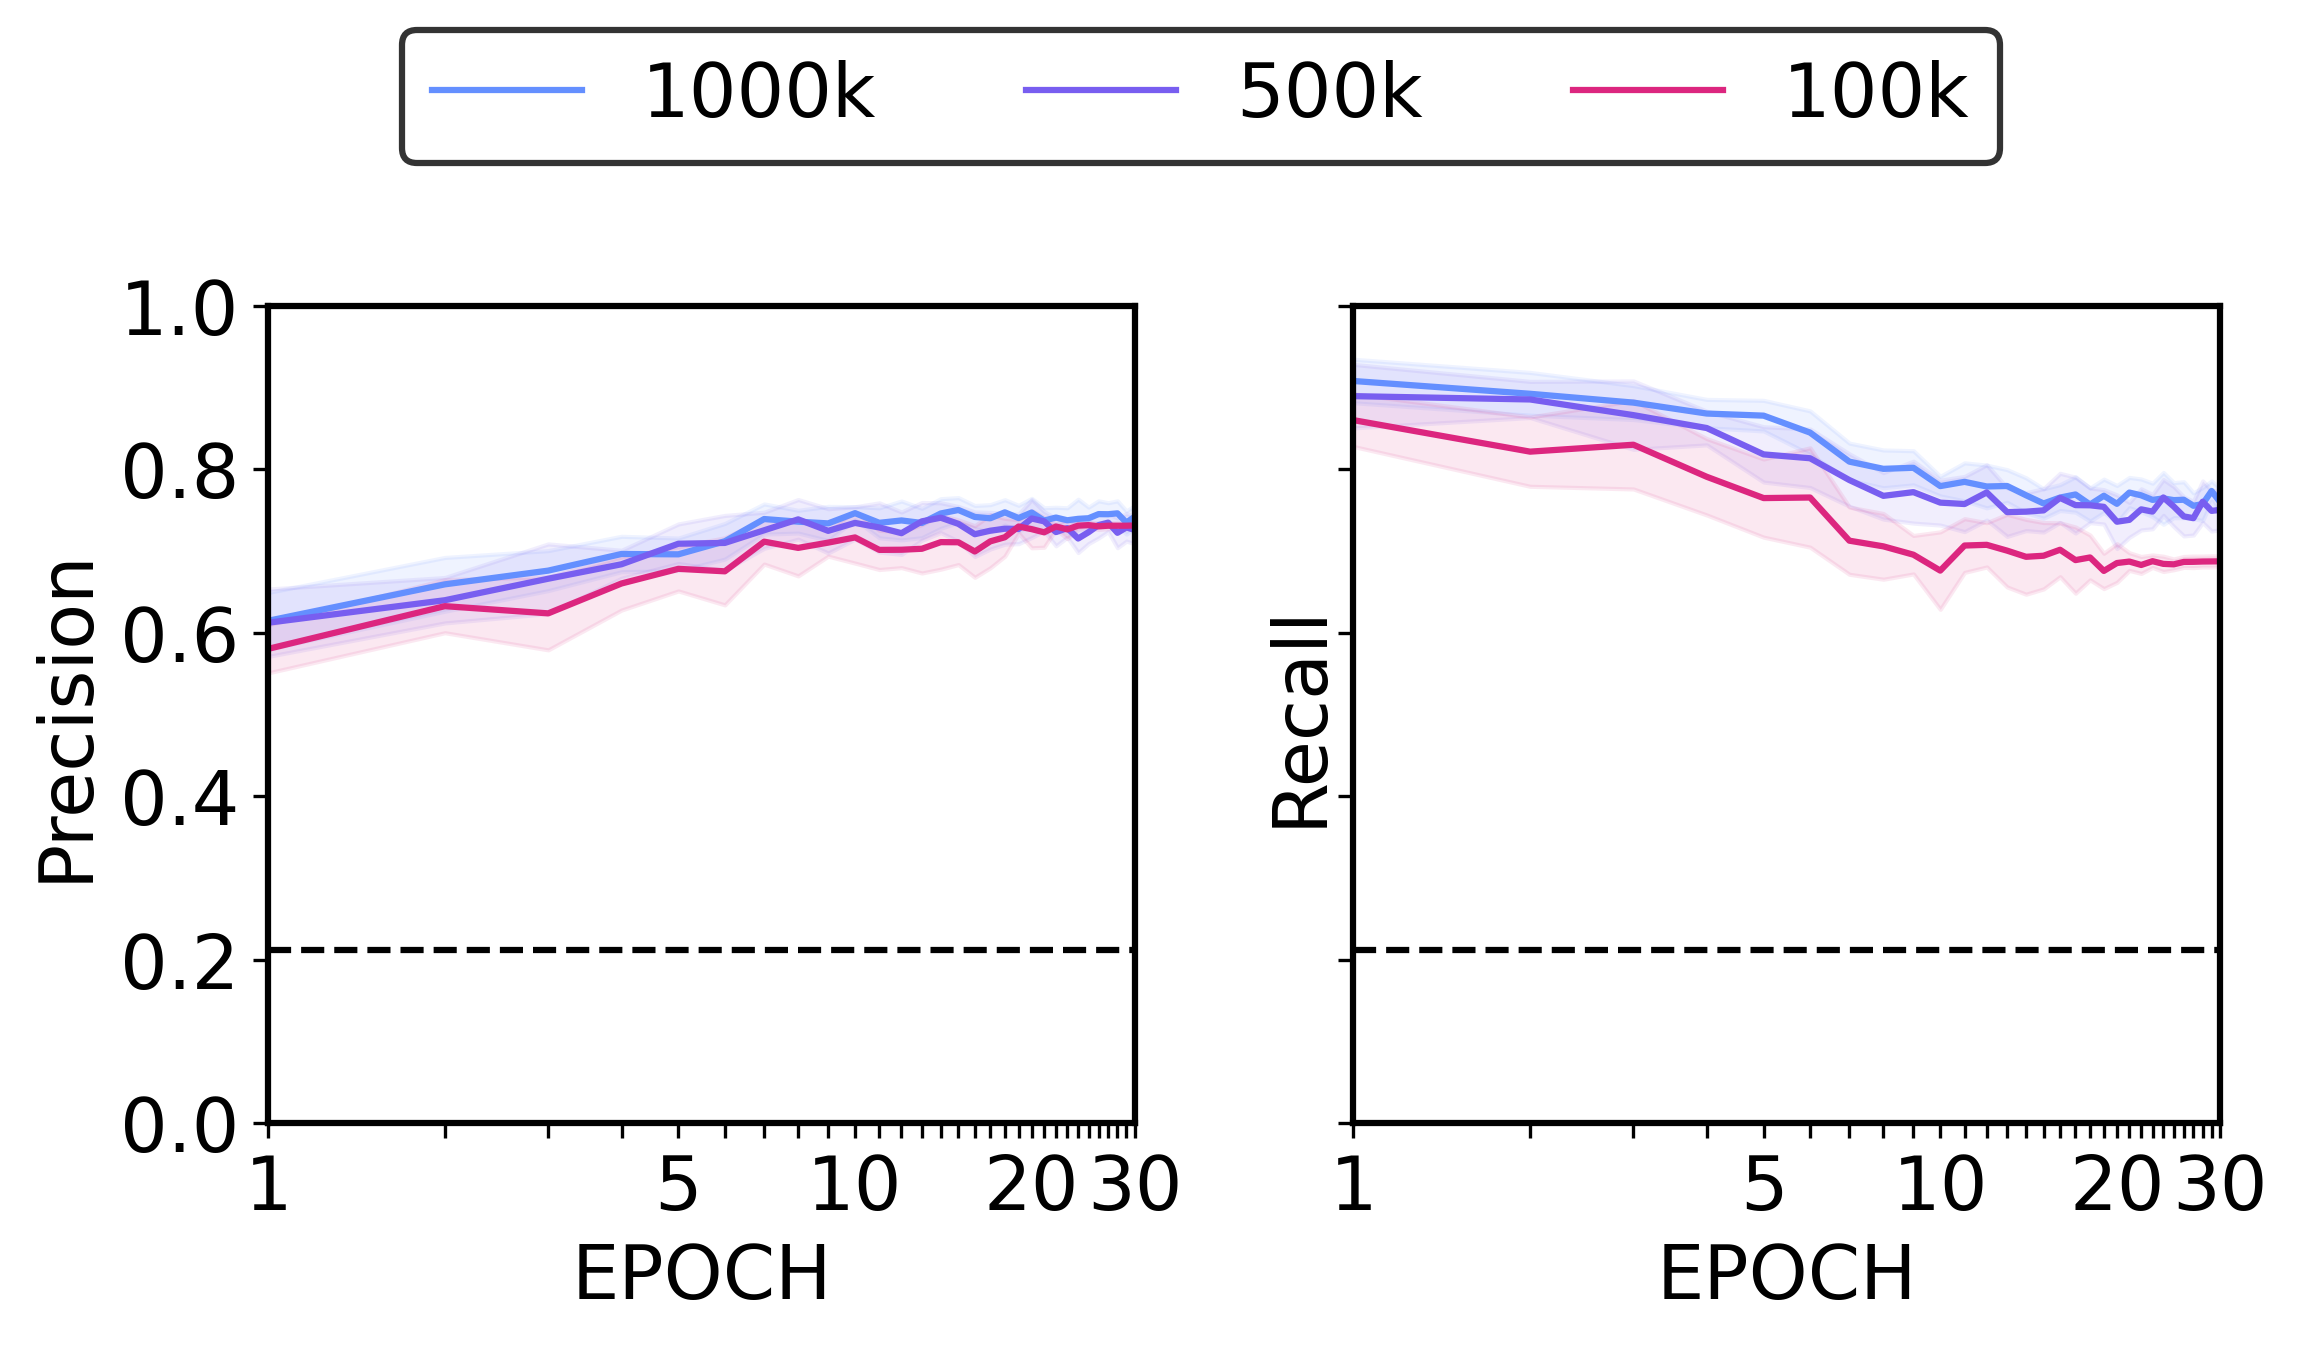

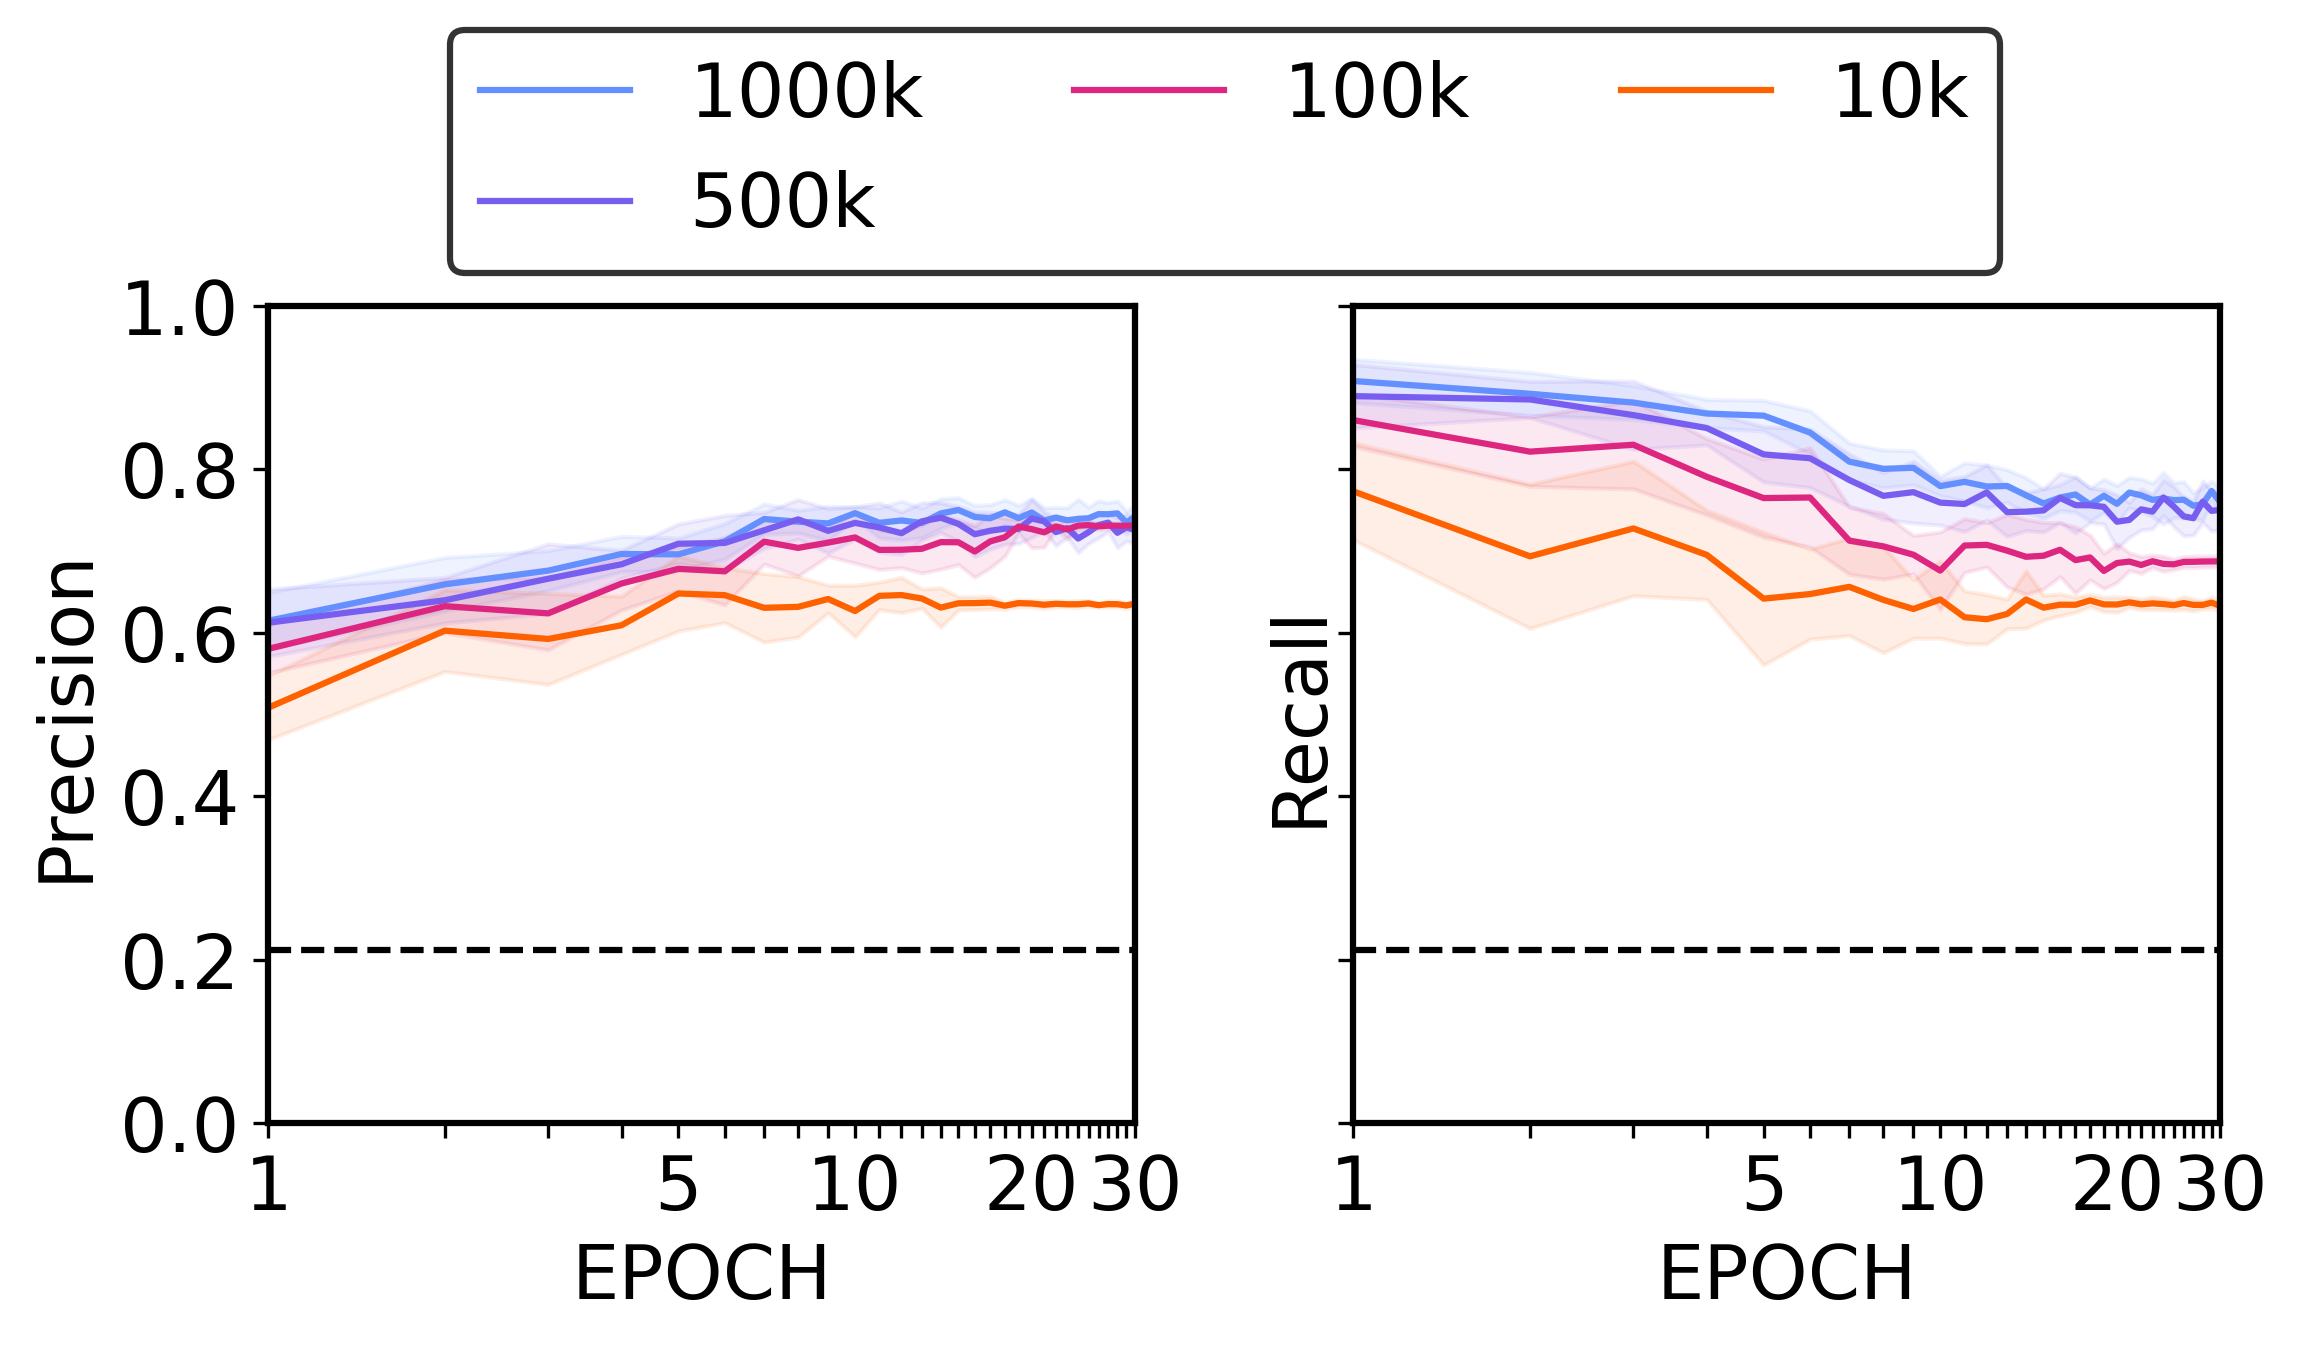

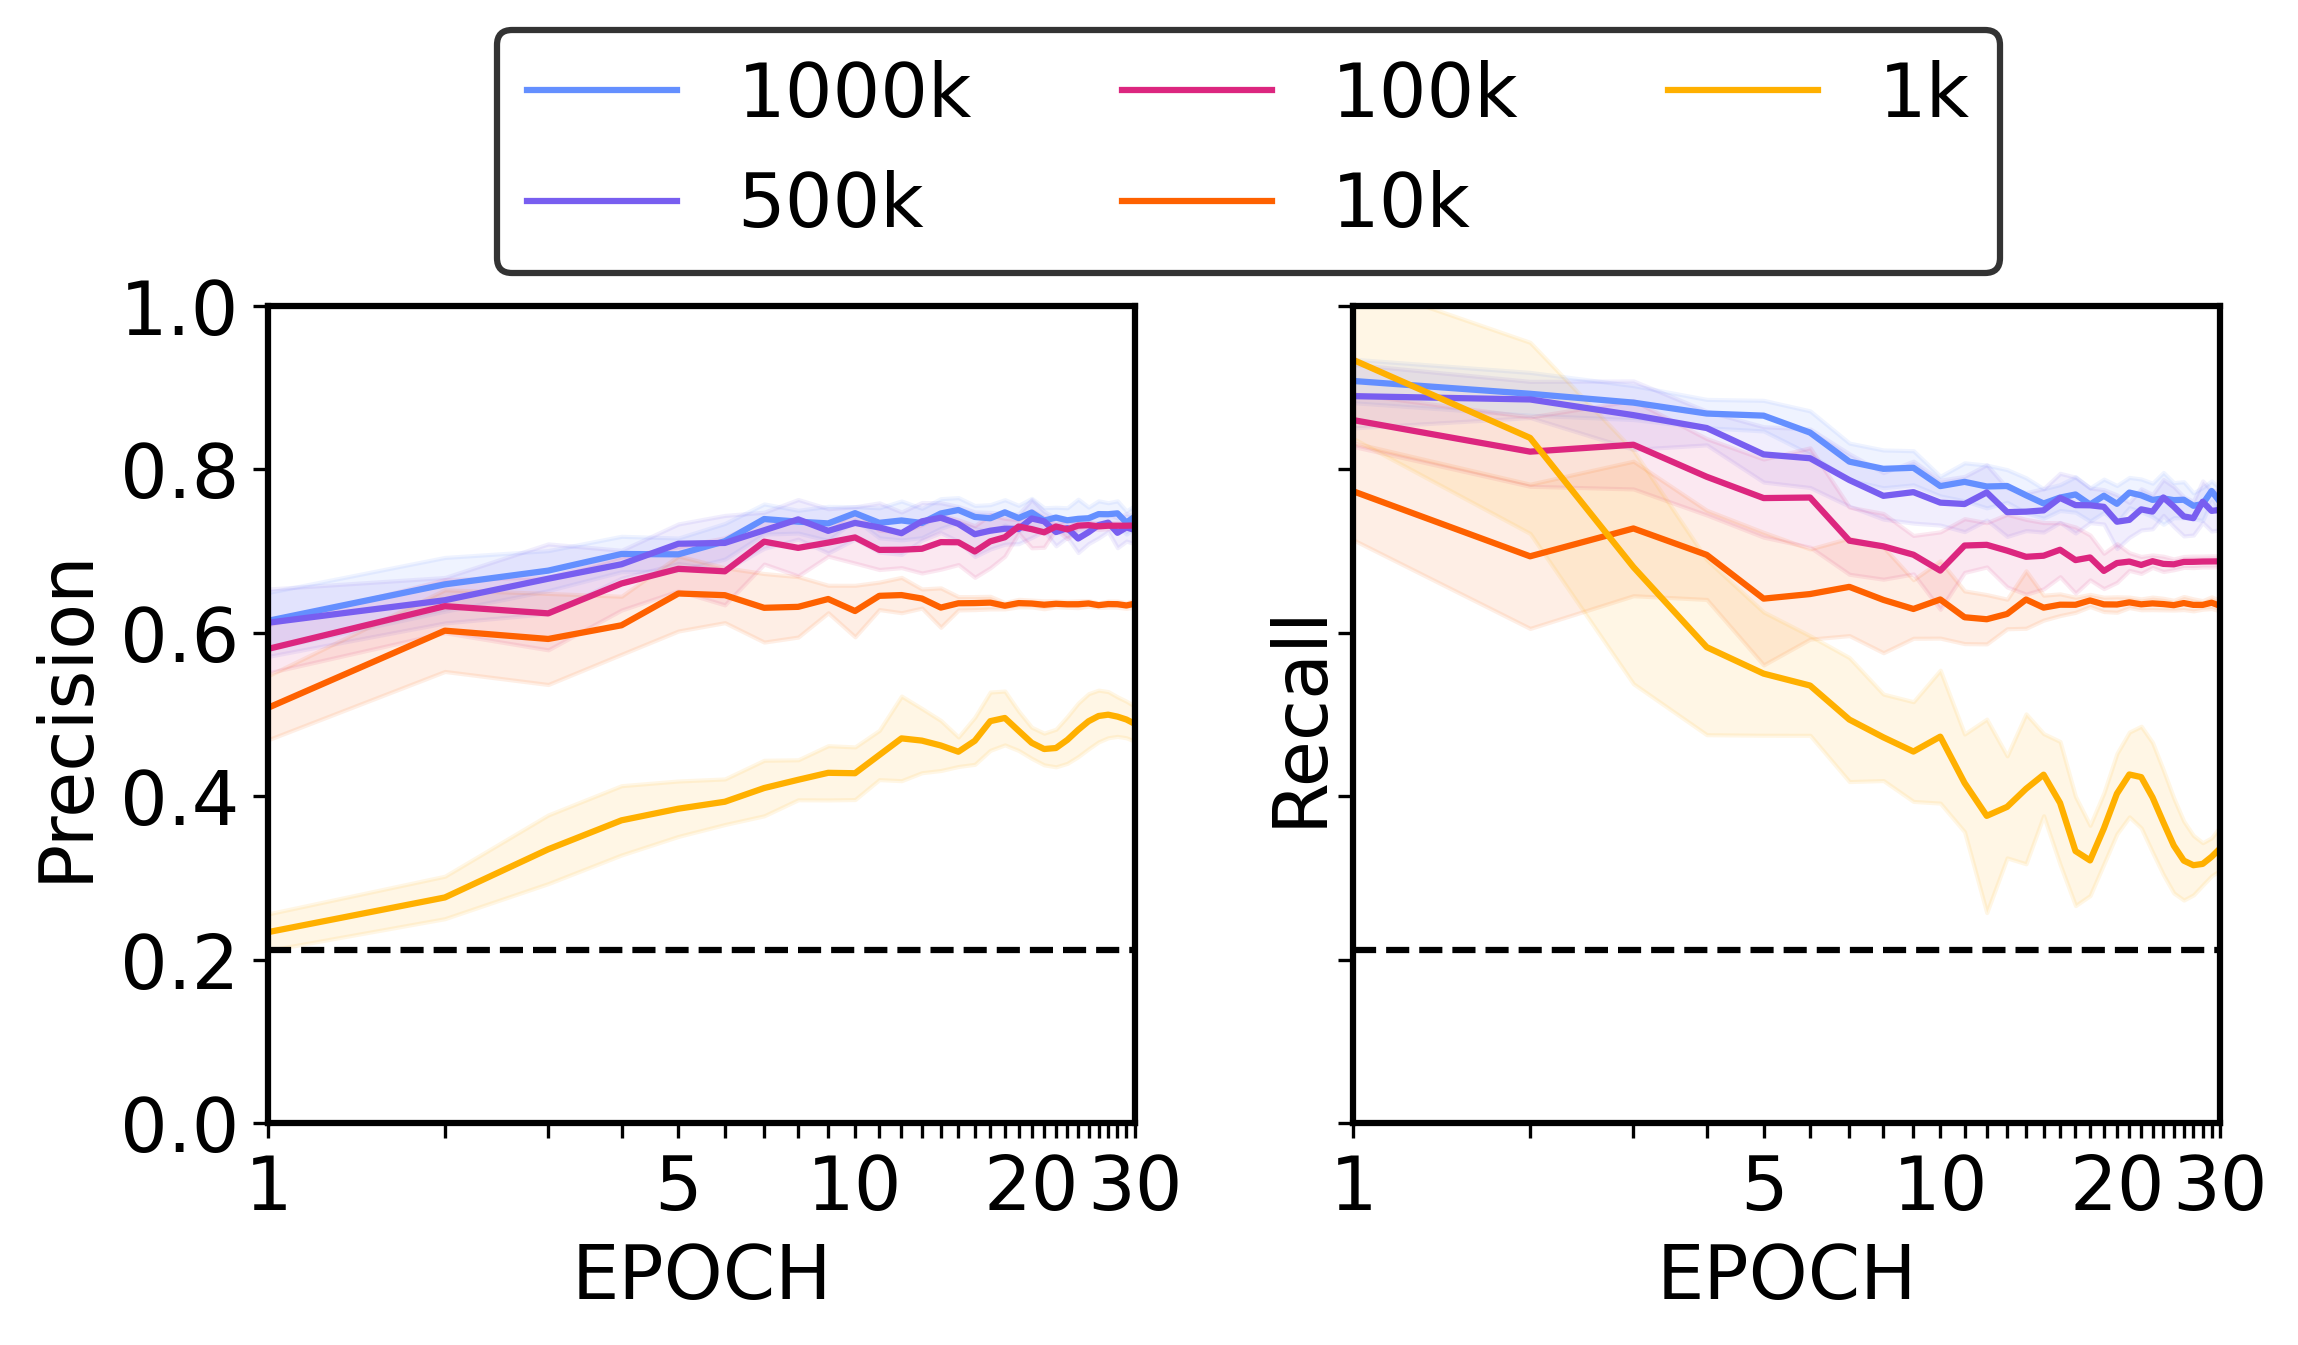

In [9]:
for order in range (5):
    fig,ax=plt.subplots(figsize=[8,4],ncols=2,sharey=True)

    for d, data_amount in enumerate(data_amount_list[::-1][:order+1]):
        ax[0].set_prop_cycle(None)
        ax[1].set_prop_cycle(None)
        for c, cnnsize in enumerate(cnnsize_list):
            precision=[]
            recall=[]
            for random_seed in random_seed_list:
                subname="/batches_resampling_"+"data_"+data_amount+"_"+cnnsize+"_cnn_"+\
                    "regularize"+"_%.3e"%epsilon+"_rs_%d/"%random_seed
                path = models_path_setA+'models_T_%d_committor_'%T+name+subname
    #             with open(path+'/trainHistoryDict', "rb") as file_pi:
    #                 history = pickle.load(file_pi)
    #             precision.append(history["val_precision"])
    #             recall.append(history["val_recall"])   
                precision.append(np.load(path+"precision.npy")[1:])
                recall.append(np.load(path+"recall.npy")[1:])   

    #         label=print_cnnsize_list[c]+" "+data_amount   
            label=plot_data_amount_list[::-1][d]
            y1=plot_bunch_timeseqdist(ax[0], np.array(precision),xt=np.arange(1,EPOCH+1),label=label,\
                                  color=color_cycle[::-1][d])
            y2=plot_bunch_timeseqdist(ax[1], np.array(recall),xt=np.arange(1,EPOCH+1),label=label,\
                                  color=color_cycle[::-1][d])
            lines1.append(y1)
            lines2.append(y2)
    ax[0].axhline(y=Ysparse.sum()/Ysparse.size, color='k',linestyle='--' )
    ax[1].axhline(y=Ysparse.sum()/Ysparse.size, color='k',linestyle='--' )   
    print("epoch=4, precision=%.3f"%lines1[-1][4-1])
    print("epoch=4, recall=%.3f"%lines2[-1][4-1])

    ax[0].set_xscale('log')
    ax[1].set_xscale('log')
    # ax[1].set_xticklabels([1,5,10,20,30])

    original_labels = [str(label) for label in np.arange(1,31)]
    labels_of_interest = [str(i) for i in [1,5,10,20,30]]
    new_labels = [label if label in labels_of_interest else "" for label in original_labels]
    ax[0].set_xticks(np.arange(1,31)) 
    ax[0].set_xticklabels(new_labels)
    ax[1].set_xticks(np.arange(1,31)) 
    ax[1].set_xticklabels(new_labels)

    ax[0].set_ylim([0,1])
    ax[0].set_xlim([1,EPOCH])
    ax[1].set_xlim([1,EPOCH])
    ax[0].set_xlabel('EPOCH')
    ax[1].set_xlabel('EPOCH')
    ax[0].set_ylabel('Precision')
    ax[1].set_ylabel('Recall')

    # ax[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))

    handles, labels = ax[1].get_legend_handles_labels()
    leg=fig.legend(handles, labels, bbox_to_anchor=(0.87, 1.17),ncol=3)
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_linewidth(1.5)
    leg.get_frame().set_linewidth(1.5)

    fig.tight_layout()
    fig.savefig("Fig5_CNN_data_model.png_%d.png"%order,dpi=200, bbox_inches = "tight")